C:\Users\y51532cw\Anaconda3new\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-4-ef7d533c86b5>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CHIhypodf['Hour'] = pd.to_datetime(CHIhypodf.Timestamp, format='%H:%M').dt.hour
C:\Users\y51532cw\Anaconda3new\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

6.434782608695652 % of the indicated time was spent hypo compared with
2.903069074418981 % of the time outside the interval and compared with
3.5149973219068023 % spent in hypo overall
absolute numbers are:
1665 / 25875
and 3585 / 123490
and 5250 / 149360
This results in a Chi Square of 98.43752881934903 and p= 3.354415435116459e-23 and df of 1
Therefore 31.71428571428571 % of all the minutes spent hypo were in the period 03:00 and 07:00 where you would expect 16.666666666666664 %
absolute numbers for last percentage are 333 and 1050


<Figure size 1728x1152 with 0 Axes>

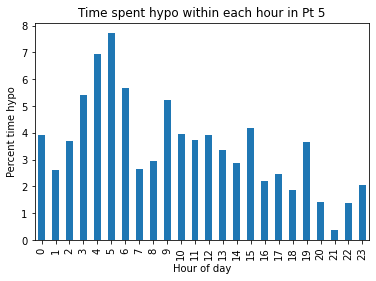

In [4]:
# This code is the original code used to generate the data for the following paper:
# Chris Worth et al. Timing of Hypoglycaemia in Patients with Hyperinsulinism (HI): Extension of the Digital Phenotype. J Med Internet res. 2021. doi: 10.2196/26957. Online ahead of print.
# Since the publication of this paper the lead author has spent significant time improving this initial code and 
# enhancing its analytic capabilities and fixing small errors. If researchers are interested in a discussion about the most
# up to date code then Dr Worth would be delighted to discuss this. Please email christophersimon.worth@mft.nhs.uk
# For the sake of transparency this original code is provided as an appendix to allow other researchers to understand the 
# process by which we arrived at our conclusions. 
# Comments are provided throughout the code to aid usability and interpretation

import numpy as np
import pandas as pd
from collections import namedtuple
import glob
import scipy
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from datetime import datetime

#This is the hypoglycaemia threshold cutoff and can be easily altered. Units are mmol/L
THRESHOLD = 3.5

def is_hypo(value):
  return value < THRESHOLD


# The location of all files should be inserted here with the corresponding filenames. Filenames should have a 
# common feature at the beginning of the name followed by distinguishing features such as numbers (e.g. filename1, filename2)
# the common feature should be inserted below in the obvious place and the * must be kep to capture all files with this
# common feature to their name. 
CHI_files = glob.glob(r"C:\filepath\filename*.csv")

CHIli = []

#For this code to read the .csv files generated by Clarity the .csv files must have the following headings exactly as they
# appear below. If they do not hav this automatically then just manually alter them. 
# All rows above the first glucose value must be deleted. 
col_list = ['Timestamp (YYYY-MM-DDThh:mm:ss)', 'Glucose Value (mmol/L)']

for filename in CHI_files:
    data = pd.read_csv(filename, usecols = col_list)
    
    #this fills values reported as "LOW" to 2.1 as this is the lowest reading value on the G4
    data['Glucose Value (mmol/L)'] = pd.to_numeric(data['Glucose Value (mmol/L)'], errors = 'coerce')
    data = data.fillna(2.1)
    
    #this changes the final value of the sreadsheet to a non-hypo value to allow the programme to close 
    if is_hypo(data['Glucose Value (mmol/L)'].iloc[-1]):
        data['Glucose Value (mmol/L)'].iloc[-1] = 3.5
    
    CHIli.append(data)

CHIdf = pd.concat(CHIli, axis=0, ignore_index=True)

# this line renames the columns
CHIdf = CHIdf.rename(columns = {"Glucose Value (mmol/L)" : "Glucose", "Timestamp (YYYY-MM-DDThh:mm:ss)" : "Timestamp"})
# this then converts the timestamp values to actual date and time data
CHIdf['Timestamp'] = pd.to_datetime(CHIdf['Timestamp'])

CHIdf['datetime'] = pd.to_datetime(CHIdf['Timestamp'])
CHIdf = CHIdf.set_index('datetime')

# This adds the all important column which reports the hour of the day
CHIdf.loc[:,'Hour'] = pd.to_datetime(CHIdf.loc[:,'Timestamp'], format='%H:%M').dt.hour

#This is the dataframe containing only hypos for the analysis
CHIhypodf = CHIdf[CHIdf['Glucose']<THRESHOLD]

CHIhypodf['Hour'] = pd.to_datetime(CHIhypodf.Timestamp, format='%H:%M').dt.hour

#This creates a dataframe which calculates the minutes spent hypo within each hour. The 5 times multiplier converts
# the number of measurements to the number of minutes. 
CHIhypodf.loc[:,'ones']=1
times = pd.to_datetime(CHIhypodf.Timestamp)
CHI_hypo_timings = CHIhypodf.groupby([times.dt.hour]).ones.sum()
CHI_hypo_frame = CHI_hypo_timings.to_frame()
CHI_hypo_frame = CHI_hypo_frame.rename(columns={"ones": "minutes_hypo"})
CHI_hypo_frame['minutes_hypo'] = (5 * CHI_hypo_frame['minutes_hypo'])


# This is the function which will give you the percentage time hypo by hour of the day 
def time_spent_in_hypo(df, hypodf, start_time, end_time):
    all_time_indicated = (df.Glucose.between_time(start_time, end_time).count())
    all_time_outside_indicated = (df.Glucose.between_time(end_time, start_time).count())
    hypo_time_indicated = (hypodf.Glucose.between_time(start_time, end_time).count())
    time_in_hypo_indicated = (hypo_time_indicated/all_time_indicated) * 100
    hypo_time_outside_indicated = (hypodf.Glucose.between_time(end_time, start_time).count())
    time_in_hypo_outside_indicated = (hypo_time_outside_indicated/all_time_outside_indicated) * 100
    
    total_time = (df.Glucose.count())
    total_hypo_time = (hypodf.Glucose.count())
    total_time_in_hypo = (total_hypo_time/total_time) * 100
    
    s1 = start_time
    s2 = end_time
    FMT = '%H:%M'
    tdelta = datetime.strptime(s2, FMT) - datetime.strptime(s1, FMT)
    hours = (tdelta.seconds)/60/60
    
    percent_of_hypo_mins = (hypo_time_indicated/total_hypo_time) * 100
    expected_percent_of_hypo_mins = (hours/24)*100
    
    Chisquare = chi2_contingency([[hypo_time_indicated, (all_time_indicated-hypo_time_indicated)], 
                               [total_hypo_time, (total_time - total_hypo_time)]])
    
    #These print values can be changed to whatever you like but are set like this to aid simple interpretation
    print(time_in_hypo_indicated, "% of the indicated time was spent hypo compared with")
    print(time_in_hypo_outside_indicated, "% of the time outside the interval and compared with")
    print(total_time_in_hypo, "% spent in hypo overall")
    print("absolute numbers are:")
    print(hypo_time_indicated*5, "/", all_time_indicated*5)
    print("and", hypo_time_outside_indicated*5, "/", all_time_outside_indicated*5)
    print("and", total_hypo_time*5, "/", total_time*5)
    print("This results in a Chi Square of", Chisquare[0], "and p=", Chisquare[1], "and df of", Chisquare[2])
    print("Therefore", percent_of_hypo_mins, "% of all the minutes spent hypo were in the period", start_time, "and", end_time, 
         "where you would expect", expected_percent_of_hypo_mins, "%")
    print("absolute numbers for last percentage are", hypo_time_indicated, "and", total_hypo_time)

# To get the data you then call the function with the dataframes indicated in brackets. The times can be changed
# to those of interest as long as they are left in this format.
# If using an environment such as Jupyter notebook, this line below is best moved to a new cell so it can be run 
# multiple times with differing times without running all of the analysis code as well. 

time_spent_in_hypo(CHIdf, CHIhypodf, '03:00', '07:00')

# We now move onto the plotting of the hypoglycaemia events by time. Again this is best moved to a new cell of its own
# if using a Python environment. 

# If there are any hours in the CHI hypo frame that do not contain any minutes hypo then this will add a row with the 
# value 0. This is required for the plot to look correct and for the masks to work. 
empty_hours = []

for value in range(0,24):
    if (CHI_hypo_frame.index == value).any() == False:
        empty_hours.append(value)
    
zeroes = [0] * len(empty_hours)

filler = pd.Series(zeroes, index= empty_hours)
CHI_hypo_frame = CHI_hypo_timings.append(filler).sort_index().to_frame()
CHI_hypo_frame.columns = ['minutes_hypo']
CHI_hypo_frame['minutes_hypo'] = (5 * CHI_hypo_frame['minutes_hypo'])

hours = []

for index in range(0,24):
    hours.append(CHIdf[CHIdf.Hour == index].Hour.count()*5)

CHI_hypo_frame['total_mins'] = hours
CHI_hypo_frame['percent_time_hypo'] = (CHI_hypo_frame.minutes_hypo / CHI_hypo_frame.total_mins) * 100
CHI_hypo_frame_plot = CHI_hypo_frame.drop(labels = 'total_mins', axis = 1)
CHI_hypo_frame_plot = CHI_hypo_frame_plot.drop(labels = 'minutes_hypo', axis = 1)

# Name of patient can be inserted here between the " " and will then appear in the title. 
# If processing data from a group of patients then this can be set to a group such as "CHI patients under 10 months" for e.g.
name = "Pt 5"
plt.figure(figsize=(24, 16))
ax = CHI_hypo_frame_plot.plot(kind='bar')
# The title and x and y labels can be set with the below
ax.set_title(f"Time spent hypo within each hour in {name}")
ax.set_xlabel('Hour of day')
ax.set_ylabel('Percent time hypo')
ax.get_legend().remove()

x = CHI_hypo_frame_plot.index
y = CHI_hypo_frame_plot.percent_time_hypo

# The masks below and subsequent lines starting with 'plt.bar(x[mask' can be used to change the colour of the bars to 
# highlight certain areas. Currently these are blanked out with a # so the entire graph with be the basic blue colour. 
# Values of masks can be changed and the subsequent colours can also be altered by removing the # from the beginnings 
# of the lines of code. 

#mask1 = (x<4)
#mask2 = ((x >= 4) & (x < 8))
#mask3 = ((x >= 8) & (x <10))
#mask4 = ((x >=10) & (x < 23))
#mask5 = (x >=23)
#mask6 = (x == 15)
#mask7 = (x > 15) 
#mask8 = (x == 19)
#mask9 = (x > 19)


#plt.bar(x[mask1], y[mask1], color = 'darkblue')
#plt.bar(x[mask2], y[mask2], color = 'skyblue')
#plt.bar(x[mask3], y[mask3], color = 'darkblue')
#plt.bar(x[mask4], y[mask4], color = 'skyblue')
#plt.bar(x[mask5], y[mask5], color = 'darkblue')
#plt.bar(x[mask6], y[mask6], color = 'skyblue')
#plt.bar(x[mask7], y[mask7], color = 'skyblue')
#plt.bar(x[mask8], y[mask8], color = 'skyblue')
#plt.bar(x[mask9], y[mask9], color = 'skyblue')

# If you want to save the chart then enter a filepath and filename below and remove the # from the line
# The dpi can be changed easily by altering the number currently set to 300. 

#plt.savefig(r"C:\filepath\filename.png", dpi = 300)
plt.show()
